## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### Load CIFAR data
* cifar 10 - labelled subsets of a larger dataset which contains 10 categories of images
* Load training and test datasets
* Apply transforms
* Define dataloaders for training and testing

In [2]:
mean = [0.49159187, 0.48234594, 0.44671956]
std  = [0.23834434, 0.23486559, 0.25264624]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(128), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                        train=True,
                                        download=True,
                                        transform=train_transform)

Files already downloaded and verified


In [6]:
testset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2)

In [8]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=2)

#### Configuring the neural network
* The input size will be the channels of the images (in_size)
* The final output will have a size equal to the number of classes for the prediction
* The convolving kernel will have a size of k_conv_size

In [9]:
in_size = 3

hid1_size = 16
hid2_size = 32
hid3_size = 64

out1_size = 2000
out2_size = 10

k_conv_size = 9

### Define the Convolutional Neural Network

<b>Conv2d: </b>Applies a 2D convolution over an input signal composed of several input planes.<br>
Parameters<br>
in_channels (int) – Number of channels in the input image<br>
out_channels (int) – Number of channels produced by the convolution<br>
kernel_size (int or tuple) – Size of the convolving kernel<br>

<b>BatchNorm2d: </b>Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .
Parameters<br>
num_features – C from an expected input of size (N,C,H,W)

<b>ReLU: </b>Activation function

<b>Maxpool2d: </b>
Parameters:<br>
kernel_size – the size of the window to take a max over

<b>Linear: </b>
Parameter:<br>

in_features: 
All the operations above used 4D Tensors of shape 

Now for fully connected layers(linear layers) we need to transform them in 1D Tensors<br>
So to the in_features of fully connected layer we will give size
out_features:<br>
num_classes = number of output labels

In [10]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
                nn.Conv2d(in_size, hid1_size, k_conv_size ), # Conv2D output = 120x120
                nn.BatchNorm2d(hid1_size),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)) # MaxPool2D output = 60x60

        self.layer2 = nn.Sequential(
                nn.Conv2d(hid1_size, hid2_size, k_conv_size), # Conv2D output = 52x52
                nn.BatchNorm2d(hid2_size),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)) # MaxPool2D output = 26x26

        self.layer3 = nn.Sequential(
                nn.Conv2d(hid2_size, hid3_size, k_conv_size), # MaxPool2D output = 18x18
                nn.BatchNorm2d(hid3_size),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)) # MaxPool2D output = 9x9

        self.layer4 = nn.Sequential(
                nn.Linear(hid3_size * k_conv_size * k_conv_size, out1_size),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(out1_size, out2_size))
    
    def forward(self, x):
        
        out = self.layer1(x)
        #print(out.shape)
        
        out = self.layer2(out)
        #print(out.shape)
        
        out = self.layer3(out)
        #print(out.shape)
        
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        
        out = self.layer4(out)
        #print(out.shape)

        return F.log_softmax(out, dim=-1)
    

In [11]:
model = ConvNet()

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [13]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=5184, out_features=2000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_fe

In [14]:
learning_rate = 0.001

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

#### Training the model and predicting accuracy

In [15]:
total_step = len(trainloader)
num_epochs = 10
loss_values = list()

for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(trainloader):
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())
            
print('Finished Training')    


Epoch [1/10], Step [2000/3125], Loss: 1.4458
Epoch [2/10], Step [2000/3125], Loss: 1.2212
Epoch [3/10], Step [2000/3125], Loss: 0.6869
Epoch [4/10], Step [2000/3125], Loss: 1.4013
Epoch [5/10], Step [2000/3125], Loss: 0.9190
Epoch [6/10], Step [2000/3125], Loss: 0.4609
Epoch [7/10], Step [2000/3125], Loss: 0.5907
Epoch [8/10], Step [2000/3125], Loss: 0.6509
Epoch [9/10], Step [2000/3125], Loss: 0.4991
Epoch [10/10], Step [2000/3125], Loss: 0.3417
Finished Training


### Model Evaluation

In [18]:
len(loss_values)

10

Text(0, 0.5, 'Loss')

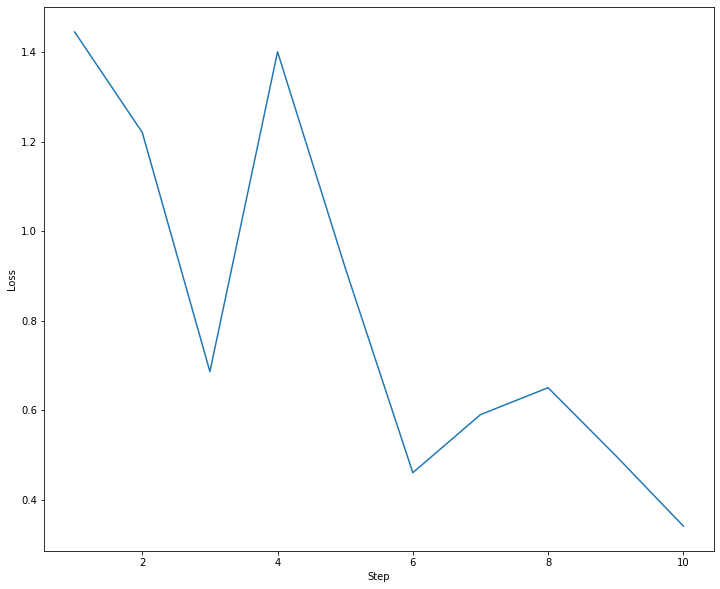

In [19]:
x = (range(1, 11))

plt.figure(figsize = (12, 10))
plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

In [20]:
model.eval()  

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the 10000 test images: {}%'\
          .format(100 * correct / total))


Accuracy of the model on the 10000 test images: 76.52%


#### Sample Prediction

In [21]:
sample_img, _ = testset[23]

In [22]:
sample_img.shape

torch.Size([3, 128, 128])

In [23]:
sample_img = np.transpose(sample_img, (1, 2, 0))
sample_img.shape

torch.Size([128, 128, 3])

In [24]:
m, M = sample_img.min(), sample_img.max()

sample_img = (1/(abs(m) * M)) * sample_img + 0.5 

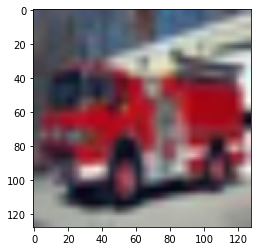

In [25]:
plt.imshow(sample_img)

In [26]:
test_img, test_label = testset[23]

test_img = test_img.reshape(-1, 3, 128, 128)

In [27]:
out_predict = model(test_img.to(device))
_,predicted = torch.max(out_predict.data, 1)

In [28]:
print("Actual Label : ", test_label)
print("Predicted Label : ", predicted.item())

Actual Label :  9
Predicted Label :  9
